In [1]:
%load_ext autoreload

In [2]:
%autoreload
from npyx import *

npyx version 2.6.1 imported.


# Load Spike Data

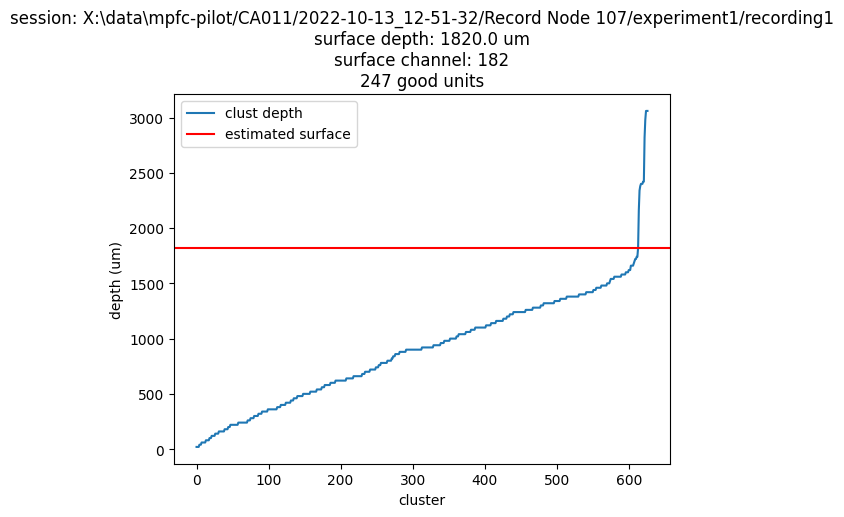

In [5]:
computer_name = os.environ['COMPUTERNAME']
if 'DESKTOP-HT3RNG1' in computer_name:
    data_path = 'D:\spikes'
else:
    data_path = 'X:\data\mpfc-pilot'
dp = f'{data_path}/CA011/2022-10-13_12-51-32/Record Node 107/experiment1/recording1'
#dp = f'{data_path}/CA011/2022-10-14_12-28-53/Record Node 107/experiment1/recording1'
clust = get_units(dp)
clust_info = get_units_info(dp)

# approximate brain surface by looking at where the units are
good_unit_depth = clust_info[clust_info.KSLabel=='good'].depth
surface_depth = np.sort(good_unit_depth)[np.argwhere(np.diff(good_unit_depth)>100)[0][0]]
plt.plot(np.sort(good_unit_depth),label='clust depth')
plt.axhline(surface_depth,color='r',label='estimated surface')
plt.xlabel('cluster')
plt.ylabel('depth (um)')
plt.legend()

# adjust depth to be relative to brain surface
clust_info['adj_depth'] = -(clust_info.depth - surface_depth)

# get channel of surface depth
cm = chan_map(dp, y_orig='tip', probe_version='1.0')
surface_channel = np.abs(np.vstack(cm)[:,2] - surface_depth).argmin()

# extract good cells
good = (clust_info.adj_depth > 0) & (clust_info.KSLabel == 'good') & (clust_info.fr > 1)
good_cells = clust_info.cluster_id[good].values
good_cells_info = clust_info.loc[good]
good_cells_info = good_cells_info.reset_index()
fs = 30e3

plt.title(f'session: {dp}\nsurface depth: {surface_depth} um\nsurface channel: {surface_channel}\n{len(good_cells)} good units');

In [6]:
def get_sync_starts(dp):
    fn = os.path.join(dp,'sync_messages.txt')
    with open(fn) as f:
        lines = f.readlines()
        data = {}
        for i,line in enumerate(lines):
            l = line.split(':')
            data[l[0]] = int(l[1].strip())

    return data

def get_message_events(dp, fs=30000):

    # get clock start
    start_times = get_sync_starts(dp)
    ap_start = [start_times[s] for s in start_times if 'AP' in s]
    assert len(ap_start) > 0, f'No AP start time found!'
    start_time = ap_start[0]

    # text messages
    ts = np.load(f'{dp}/events/MessageCenter/sample_numbers.npy') - start_time # offset by recording start time
    txt = np.load(f'{dp}/events/MessageCenter/text.npy')
    txt = [t.decode('UTF-8') for t in txt]
    u,i = np.unique(ts,return_index=True)
    ts = ts[i] / fs # convert to seconds
    txt = [txt[j] for j in i]

    messages = {}
    for i,key in enumerate(txt):
        messages[key] = ts[i]


    return messages, start_time



In [7]:
messages, start_time = get_message_events(dp)
messages

{'starting robot wheel tests': 1009.0521666666667,
 't1': 1075.8188333333333,
 't2': 1092.7188333333334,
 't3 - 60s': 1119.3855,
 't4 - on-off 1hz 30 secs': 1195.8355,
 't5 - moved closer ran 30 s': 1277.5355,
 't6 - moved closer ran 60 s': 1324.6521666666667,
 'motor tests': 1402.2855,
 't1 - trigger puff for 30 seconds': 1427.6688333333334,
 't2 - moved closer and trigger puff 30 sec': 1477.2688333333333,
 '(didnt send messages when connected)': 1519.0188333333333,
 'ran motor low speed, close to mouse 60 s': 1634.0355,
 'baseline 60s': 1745.8021666666666}

In [8]:
def compute_event_change(good_cells, event, win=30):

    time_span = [event-win, event+win]
    trains = [trn(dp, u, periods=[time_span])/fs for u in good_cells]
    fr_change = [[sum(i < event) / win, sum(i >= event) / win] for i in trains]

    return np.diff(np.vstack(fr_change), axis=1), trains

def plot_event_change(good_cells, t, fr_null, color='k'):

    win = 30
    fr_change, trains = compute_event_change(good_cells, t, win=win)
    time_span = [messages[event]-win, messages[event]+win]
    sorti = np.argsort(-good_cells_info.depth)

    prctile = []
    for i,c in enumerate(good_cells):
        prctile.append(stats.percentileofscore(np.hstack(fr_null)[i,:].squeeze(), fr_change[i][0]))
    prctile = npa(prctile)
    nsig = np.sum((prctile > 97.5) | (prctile < 2.5))
    n = len(prctile)

    # set up figure
    import matplotlib.gridspec as gridspec
    fig = plt.figure(figsize=(7,2), constrained_layout=True)
    gs = fig.add_gridspec(1,3)
    ax = []

    ax.append(fig.add_subplot(gs[0,0:2]))
    ax[0].eventplot([trains[i] for i in sorti],color=color,linewidth=0.5);
    ax[0].axvline(messages[event],color='k')
    ax[0].set_ylim([0, len(fr_change)])
    ax[0].set_xlim(time_span)
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Unit (sorted by depth)')
    ax[0].set_title(event)

    ax.append(fig.add_subplot(gs[0,2]))
    ax[1].hist(fr_change, bins=20, color='k', alpha=0.5, edgecolor='k')
    ax[1].set_xlabel('FR change (Hz)')
    ax[1].set_ylabel('n units')
    stat = stats.wilcoxon(np.diff(np.vstack(fr_change)))
    ax[1].set_title(f'significant units: {nsig}/{n} ({nsig/n:03.2f})')

    return fig


In [8]:
# sample 1000 time periods randomly from the baseline period and compute FR change
from tqdm.notebook import tqdm
import pickle

its = 10000
fn = f'./results/fr_shuffle_{its}.pkl'

if os.path.exists(fn):
    with open(fn, 'rb') as handle:
        print(f'{fn} found, loading...')
        fr_null = pickle.load(handle)

else:
    fr_null = []
    for i in tqdm(range(its)):
        t = np.random.uniform(100,1000)
        frc,_ = compute_event_change(good_cells, t, win=30)
        fr_null.append(frc)

    with open(fn, 'wb') as handle:
        pickle.dump(fr_null, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/10000 [00:00<?, ?it/s]

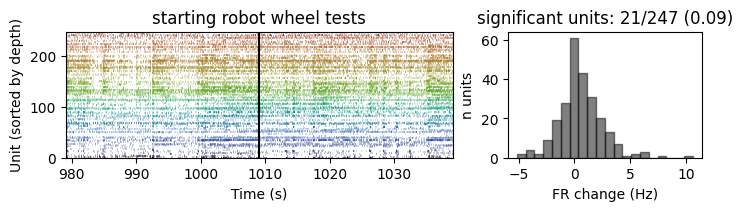

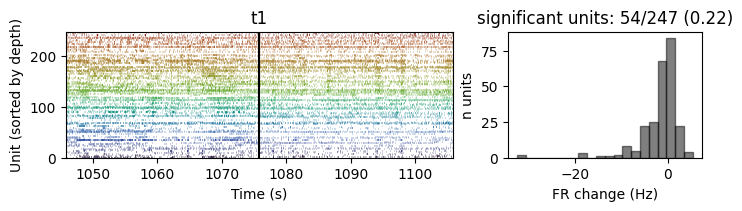

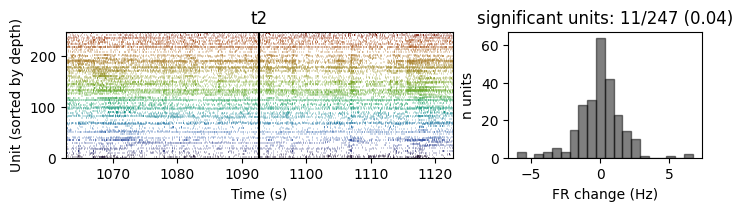

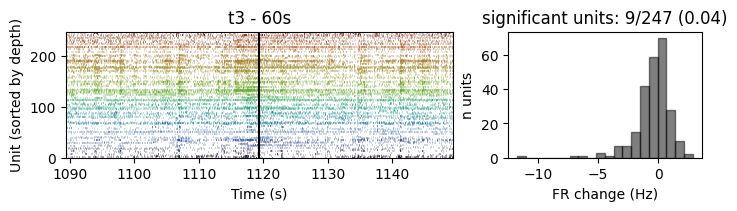

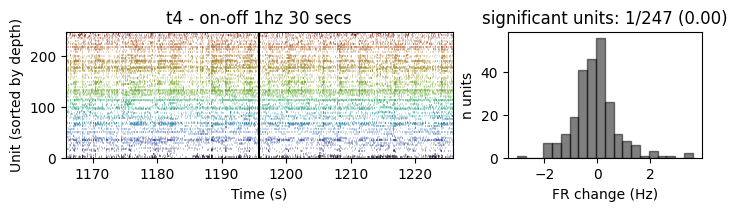

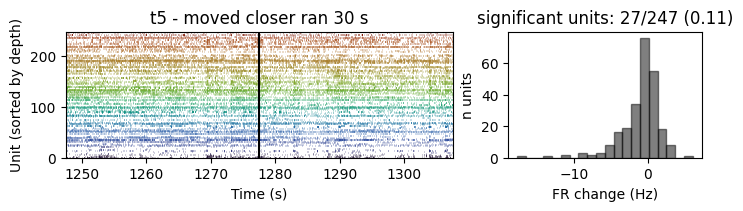

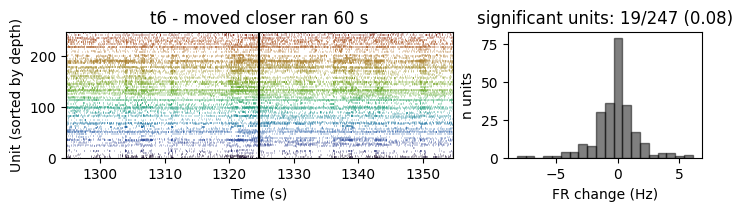

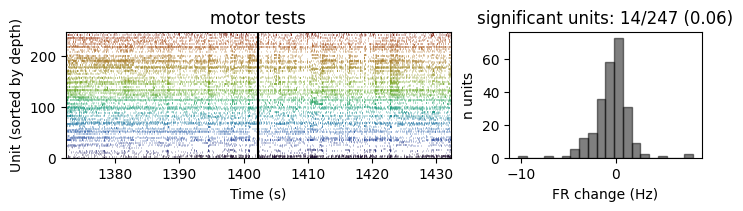

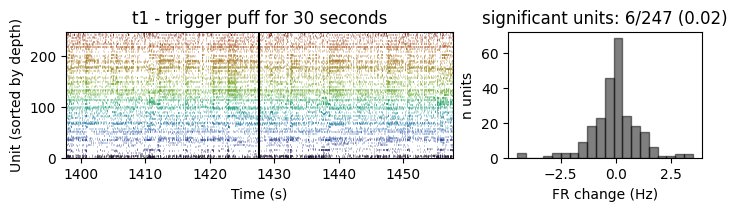

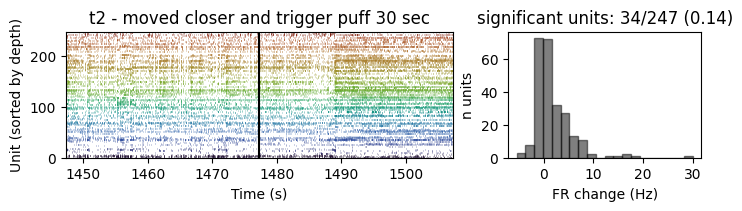

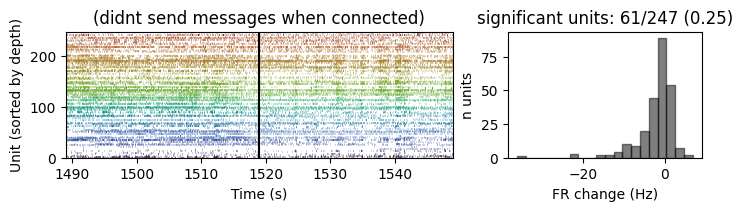

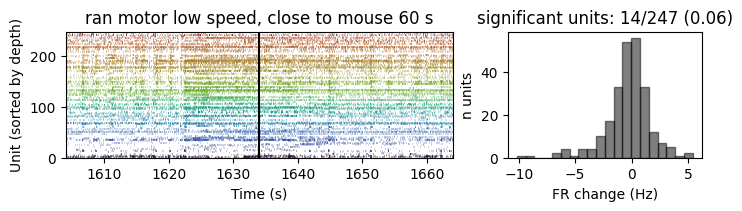

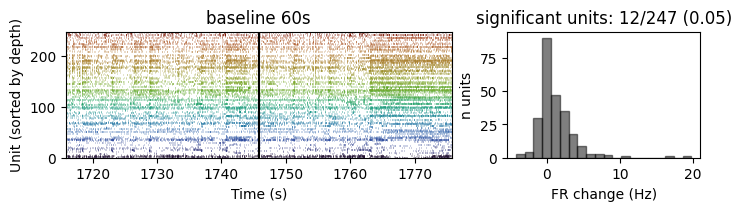

In [11]:
# set up colormap
from matplotlib import colors, cm
norm = colors.Normalize(vmin=0, vmax=surface_channel)
cmap = cm.turbo
m = cm.ScalarMappable(norm=norm, cmap=cmap)
colormap = m.to_rgba(good_cells_info.ch) / 1.5

for event in messages.keys():
    fig = plot_event_change(good_cells, messages[event], fr_null, colormap);
    fig.savefig(f'./results/fr_test_{event}.pdf', dpi=300, bbox_inches='tight')

## Spike SNR Analysis

In [37]:
def load_binary_chunk(dp, times, channels=np.arange(384), filt_key='lowpass', scale=True, verbose=False):
    dp = Path(dp)
    meta = read_metadata(dp)
    fname = Path(dp)/meta[filt_key]['binary_relative_path'][2:]
    print(fname)
    
    fs = meta[filt_key]['sampling_rate']
    Nchans=meta[filt_key]['n_channels_binaryfile']
    bytes_per_sample=2
    
    assert len(times)==2
    assert times[0]>=0
    assert times[1]<meta['recording_length_seconds']
    
    # Format inputs
    ignore_ks_chanfilt = True
    channels=assert_chan_in_dataset(dp, channels, ignore_ks_chanfilt)
    t1, t2 = int(np.round(times[0]*fs)), int(np.round(times[1]*fs))
    
    vmem=dict(psutil.virtual_memory()._asdict())
    chunkSize = int(fs*Nchans*bytes_per_sample*(times[1]-times[0]))
    if verbose:
        print('Used RAM: {0:.1f}% ({1:.2f}GB total).'.format(vmem['used']*100/vmem['total'], vmem['total']/1024/1024/1024))
        print('Chunk size:{0:.3f}MB. Available RAM: {1:.3f}MB.'.format(chunkSize/1024/1024, vmem['available']/1024/1024))
    if chunkSize>0.9*vmem['available']:
        print('WARNING you are trying to load {0:.3f}MB into RAM but have only {1:.3f}MB available.\
              Pick less channels or a smaller time chunk.'.format(chunkSize/1024/1024, vmem['available']/1024/1024))
        return
    
    # Get chunk from binary file
    with open(fname, 'rb') as f_src:
        # each sample for each channel is encoded on 16 bits = 2 bytes: samples*Nchannels*2.
        byte1 = int(t1*Nchans*bytes_per_sample)
        byte2 = int(t2*Nchans*bytes_per_sample)
        bytesRange = byte2-byte1

        f_src.seek(byte1)

        bData = f_src.read(bytesRange)
        
    # Decode binary data
    # channels on axis 0, time on axis 1
    assert len(bData)%2==0
    rc = np.frombuffer(bData, dtype=np.int16) # 16bits decoding
    rc = rc.reshape((int(t2-t1), Nchans)).T
    rc = rc[:-1,:] # remove sync channel
    
    # Scale data
    if scale:
        rc = rc * meta['bit_uV_conv_factor'] # convert into uV
    
    return rc

Load data and spikes

In [113]:
win = 30
event = messages['t2']
time_span = [event-win, event+win]
t = np.arange(time_span[0], time_span[1], 1/fs)

data = load_binary_chunk(dp, time_span, filt_key='highpass')
spks, spike_clusters, spike_samples = load_spikes(dp, good_cells)

X:\data\mpfc-pilot\CA011\2022-10-13_12-51-32\Record Node 107\experiment1\recording1\continuous\Neuropix-PXI-100.ProbeA-AP\continuous.dat


Compute and plot MAD of background

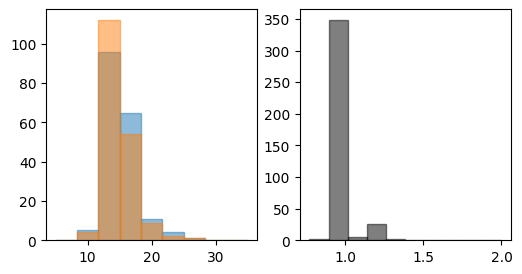

In [344]:
#plt.imshow(data, extent=[time_span[0],time_span[1],0,data.shape[0]], aspect=0.1, vmin=-50, vmax=50)
noise_level_pre = stats.median_abs_deviation(data[:,t < event].T, scale='normal')
noise_level_post = stats.median_abs_deviation(data[:,t > event].T, scale='normal')

fig,ax = plt.subplots(1,2, figsize=(6,3))
ax[0].hist(noise_level_pre[0:surface_channel], color='tab:blue', edgecolor='tab:blue', alpha=0.5, bins=np.linspace(5,35,10));
ax[0].hist(noise_level_post[0:surface_channel], color='tab:orange', edgecolor='tab:orange', alpha=0.5, bins=np.linspace(5,35,10));

ax[1].hist(noise_level_pre / noise_level_post, color='k', edgecolor='k', alpha=0.5, bins=10);

Compute and unit SNR

In [382]:
def get_unit_snr(dp, unit, data):

    waveforms = wvf(dp, unit)
    peak_channel = waveforms.mean(0).max(0).argmax()
    w = waveforms.mean(0)[:,peak_channel]
    amplitude = np.max(np.abs(w))
    noise_level = get_unit_noise_level(dp, unit, data)

    return(amplitude / noise_level)

def get_unit_noise_level(dp, unit, data):

    peak_channel = get_peak_chan(dp, unit)
    return (stats.median_abs_deviation(data[peak_channel, :], scale='normal'))

sorti = np.argsort(-good_cells_info.Amplitude).values

data_pre = data[:, t < event]
data_post = data[:, t > event]

snr_pre = []
snr_post = []
for i in tqdm(sorti):
    unit = good_cells_info.loc[sorti[i]].cluster_id

    snr_pre.append(get_unit_snr(dp, unit, data_pre))
    snr_post.append(get_unit_snr(dp, unit, data_post))

100%|██████████| 247/247 [00:45<00:00,  5.43it/s]


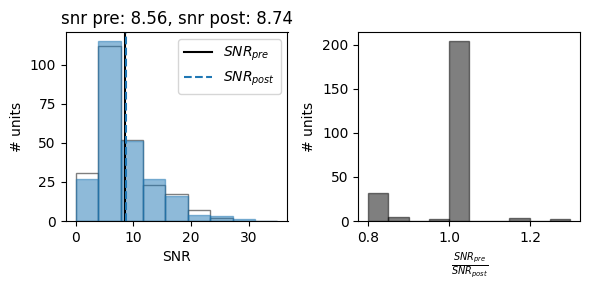

In [436]:
d_snr = np.array(snr_pre) / np.array(snr_post)

fig,ax = plt.subplots(1,2, figsize=(6,3))
ax[0].hist(snr_pre, color='white', edgecolor='k', alpha=0.5, bins=np.linspace(0,35,10));
ax[0].hist(snr_post, color='tab:blue', edgecolor='tab:blue', alpha=0.5, bins=np.linspace(0,35,10));
ax[0].axvline(np.mean(snr_pre), color='k')
ax[0].axvline(np.mean(snr_post), linestyle='--', color='tab:blue')
ax[0].set_xlabel('SNR')
ax[0].set_ylabel('# units')
ax[0].set_title(f'snr pre: {np.mean(snr_pre):0.2f}, snr post: {np.mean(snr_post):0.2f}')
ax[0].legend([r'$SNR_{pre}$',r'$SNR_{post}$'])

ax[1].hist(d_snr, color='k', edgecolor='k', alpha=0.5, bins=10);
ax[1].set_xlabel(r'$\frac{SNR_{pre}}{SNR_{post}}$')
ax[1].set_ylabel('# units')
plt.tight_layout()

fig.savefig('./results/_snrs.pdf', bbox_inches='tight')

In [423]:
def plot_unit_trace(dp, unit, time_span=[0,1], win = [0.005,0.005], figsize=(3,3)):
    spks = trn(dp, unit) / fs
    spki = (spks > time_span[0]) & (spks < time_span[1])
    if any(spki): 
        waveforms = wvf(dp, unit)
        peak_channel = waveforms.mean(0).max(0).argmax()
        fig = plot_raw_units(dp, times=[spks[spki][0] - win[0], spks[spki][0] + win[1]], units = [unit], 
                            channels=peak_channel, colors = [[1,0,0]], lw=0.5, offset=300, figsize=figsize, Nchan_plot=1,
                            med_sub=1, whiten=1, hpfilt=1, bg_alpha=0.35);

    else:
        print(f'no spikes found in window {win}')

    return fig


def plot_waveform_spikes(dp, unit, time_span, data=[], ax=[]):

    spike_ids = (spike_clusters == unit) & (spike_samples.squeeze()/fs > time_span[0]) & (spike_samples.squeeze()/fs < time_span[1])
    peak_chan = get_peak_chan(dp, unit)
    waveforms = wvf(dp, unit, spike_ids=[i[0] for i in np.argwhere(spike_ids)])
    w = waveforms.mean(0)[:,peak_chan]
    w = w - np.mean(w[0:10])
    w_s = waveforms.std(0)[:,peak_chan]
    w_time = np.arange(len(w)) * 1000 / fs

    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(2,2))
    else:
        fig = None

    ax.fill_between(w_time, w+w_s, w-w_s, alpha=0.4, color='k')
    ax.plot(w_time,w,color='k')

    if len(data) > 0:
        noise_level = get_unit_noise_level(dp, unit, data)
        SNR = np.abs(w).max() / noise_level
        ax.axhline(noise_level, color='r', linestyle='--', linewidth=1)
        ax.axhline(-noise_level, color='r', linestyle='--', linewidth=1)
        ax.set_title(f'unit {unit} (SNR={SNR:3.2f})')

    else:
        ax.set_title(f'unit {unit})')
    ax.set_xlim(0,w_time.max())

    return fig

def plot_waveform_snr(dp, unit, data=[], ax=None):

    waveforms = wvf(dp, unit, n_waveforms=1000)
    peak_channel = waveforms.mean(0).max(0).argmax()
    w = waveforms.mean(0)[:,peak_channel]
    w = w - np.mean(w[0:10])
    w_s = waveforms.std(0)[:,peak_channel]
    w_time = np.arange(len(w)) * 1000 / fs

    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(2,2))
    else:
        fig = None

    ax.fill_between(w_time, w+w_s, w-w_s, alpha=0.4, color='k')
    ax.plot(w_time, w, 'k', zorder=10)
    if len(data) > 0:
        noise_level = get_unit_noise_level(dp, unit, data)
        SNR = np.abs(w).max() / noise_level
        ax.axhline(noise_level, color='r', linestyle='--', linewidth=1)
        ax.axhline(-noise_level, color='r', linestyle='--', linewidth=1)
        ax.set_title(f'unit {unit} (SNR={SNR:3.2f})')

    else:
        ax.set_title(f'unit {unit})')
    ax.set_xlim(0,w_time.max())
    
    return fig



True
True
plotting unit 813...
plotting spike 0/41...
plotting spike 1/41...
plotting spike 2/41...
plotting spike 3/41...
plotting spike 4/41...
plotting spike 5/41...
plotting spike 6/41...
plotting spike 7/41...
plotting spike 8/41...
plotting spike 9/41...
plotting spike 10/41...
plotting spike 11/41...
plotting spike 12/41...
plotting spike 13/41...
plotting spike 14/41...
plotting spike 15/41...
plotting spike 16/41...
plotting spike 17/41...
plotting spike 18/41...
plotting spike 19/41...
plotting spike 20/41...
plotting spike 21/41...
plotting spike 22/41...
plotting spike 23/41...
plotting spike 24/41...
plotting spike 25/41...
plotting spike 26/41...
plotting spike 27/41...
plotting spike 28/41...
plotting spike 29/41...
plotting spike 30/41...
plotting spike 31/41...
plotting spike 32/41...
plotting spike 33/41...
plotting spike 34/41...
plotting spike 35/41...
plotting spike 36/41...
plotting spike 37/41...
plotting spike 38/41...
plotting spike 39/41...
plotting spike 40/4

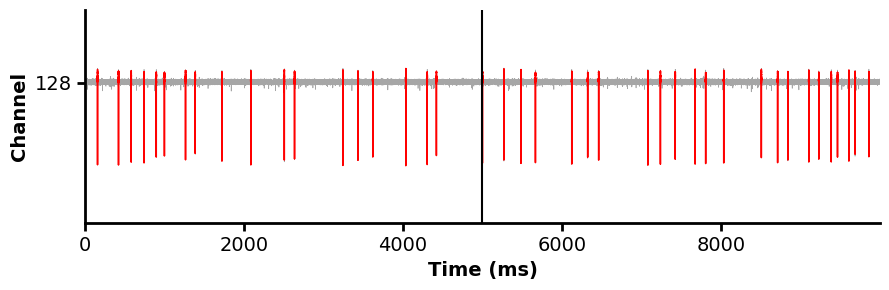

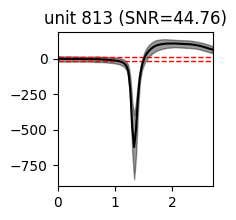

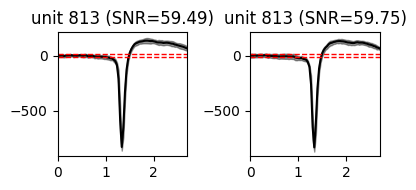

In [425]:
offset = 5
time_span = [event - offset, event + offset]
unit = good_cells[sorti[1]]

# plot raw spikes
fig = plot_unit_trace(dp, unit, time_span, win=[offset,offset], figsize=(9,3));
plt.axvline(offset * 1000, color='k');
fig.savefig(f'./results/{unit:03d}_spike_trace.pdf', bbox_inches='tight')

# plot waveform and snr
fig = plot_waveform_snr(dp, unit, data);
fig.savefig(f'./results/{unit:03d}_waveform_snr.pdf', bbox_inches='tight')

# plot spikes before and after
fig,ax = plt.subplots(1,2,figsize=(4,2))
plot_waveform_spikes(dp, unit, [time_span[0], event], data=data_pre, ax=ax[0])
plot_waveform_spikes(dp, unit, [event, time_span[1]], data=data_post, ax=ax[1])
ax[1].set_ylim(ax[0].get_ylim())
plt.tight_layout()
fig.savefig(f'./results/{unit:03d}_waveform_snr_pre_post.pdf', bbox_inches='tight')

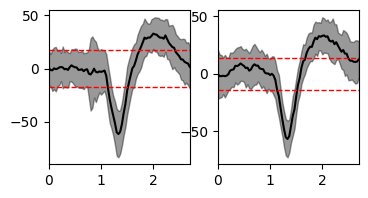

In [351]:
unit

671

# Plot and analyze ISI dist

NameError: name 'ts' is not defined

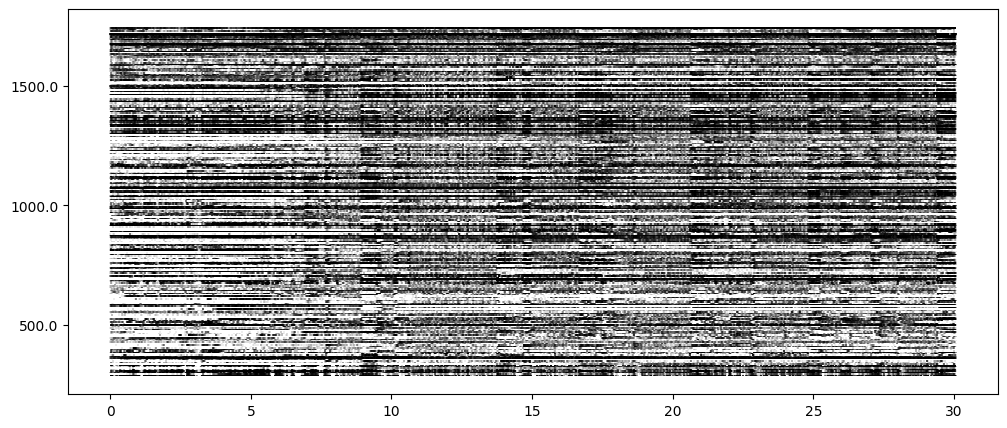

In [11]:
# sort cells by depth
Y = good_cells_info.adj_depth
X = spikes
spks_sort = [x for _, x in sorted(zip(Y, X), key=lambda pair: pair[0])]
fig,ax = plt.subplots(1,1,figsize=(12,5))
_ = ax.eventplot(spks_sort,colors='k',linewidths=0.1)
plt.axis('tight')
tickl = np.unique(np.sort(good_cells_info.adj_depth)[(np.sort(good_cells_info.adj_depth) % 500) == 0])
ticks = [np.argmax(np.sort(good_cells_info.adj_depth) >= i) for i in tickl]
ax.yaxis.set_ticks(ticks)
ax.yaxis.set_ticklabels(tickl)
for i,t in enumerate(ts):
    ax.axvline(t,color='r')
    ax.text(t,-5,str(i),color='r')
    print(f'{i}) {txt[i]}')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Depth (um from dura)')
ax.set_xlim([0,30])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().invert_yaxis()
#fig.savefig('spike_raster.pdf')

WilcoxonResult(statistic=3318.0, pvalue=9.729993047975963e-05)


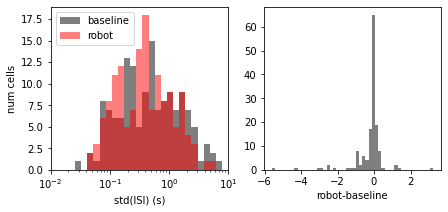

In [ ]:
# for each cell, compute std of ISIs before and after 15 minutes
pre_std = []
post_std = []
for u in spks:
    pre_std.append(np.nanstd(np.diff(u[u<15]) * 60))
    post_std.append(np.nanstd(np.diff(u[u>15]) * 60))
pre_std = np.array(pre_std)
post_std = np.array(post_std)
mn,mx = 0.01,10
bins = np.logspace(np.log10(mn),np.log10(mx),30)
fig,ax = plt.subplots(1,2,figsize=(7,3))
ax[0].hist(pre_std,bins,color='k',alpha=0.5,label='baseline')
ax[0].hist(post_std,bins,color='r',alpha=0.5,label='robot')
ax[0].set_xscale('log')
ax[0].set_xlim([mn,mx])
ax[0].set_xlabel('std(ISI) (s)')
ax[0].set_ylabel('num cells')
ax[0].legend()

ax[1].hist(post_std-pre_std,50,color='k',alpha=0.5)
ax[1].set_xlabel('robot-baseline')

from scipy.stats import wilcoxon
print(wilcoxon(post_std,pre_std))

# Synchronize data streams
First load timestamps for relevant files

In [ ]:
ts = {'ap': np.load(os.path.join(dp,'continuous','Neuropix-PXI-100.ProbeA-AP','timestamps.npy')),\
      'lfp': np.load(os.path.join(dp,'continuous','Neuropix-PXI-100.ProbeA-LFP','timestamps.npy')),\
      'nidaq': np.load(os.path.join(dp,'continuous','NI-DAQmx-103.PXI-6133','timestamps.npy'))}

Load raw binary data

In [ ]:
def load_binary_chunk(dp, times, channels=np.arange(384), filt_key='lowpass', scale=True, verbose=False):
    dp = Path(dp)
    meta = read_metadata(dp)
    fname = Path(dp)/meta['lowpass']['binary_relative_path'][2:]
    
    fs = meta[filt_key]['sampling_rate']
    Nchans=meta[filt_key]['n_channels_binaryfile']
    bytes_per_sample=2
    
    assert len(times)==2
    assert times[0]>=0
    assert times[1]<meta['recording_length_seconds']
    
    # Format inputs
    ignore_ks_chanfilt = True
    channels=assert_chan_in_dataset(dp, channels, ignore_ks_chanfilt)
    t1, t2 = int(np.round(times[0]*fs)), int(np.round(times[1]*fs))
    
    vmem=dict(psutil.virtual_memory()._asdict())
    chunkSize = int(fs*Nchans*bytes_per_sample*(times[1]-times[0]))
    if verbose:
        print('Used RAM: {0:.1f}% ({1:.2f}GB total).'.format(vmem['used']*100/vmem['total'], vmem['total']/1024/1024/1024))
        print('Chunk size:{0:.3f}MB. Available RAM: {1:.3f}MB.'.format(chunkSize/1024/1024, vmem['available']/1024/1024))
    if chunkSize>0.9*vmem['available']:
        print('WARNING you are trying to load {0:.3f}MB into RAM but have only {1:.3f}MB available.\
              Pick less channels or a smaller time chunk.'.format(chunkSize/1024/1024, vmem['available']/1024/1024))
        return
    
    # Get chunk from binary file
    with open(fname, 'rb') as f_src:
        # each sample for each channel is encoded on 16 bits = 2 bytes: samples*Nchannels*2.
        byte1 = int(t1*Nchans*bytes_per_sample)
        byte2 = int(t2*Nchans*bytes_per_sample)
        bytesRange = byte2-byte1

        f_src.seek(byte1)

        bData = f_src.read(bytesRange)
        
    # Decode binary data
    # channels on axis 0, time on axis 1
    assert len(bData)%2==0
    rc = np.frombuffer(bData, dtype=np.int16) # 16bits decoding
    rc = rc.reshape((int(t2-t1), Nchans)).T
    rc = rc[:-1,:] # remove sync channel
    
    # Scale data
    if scale:
        rc = rc * meta['bit_uV_conv_factor'] # convert into uV
    
    return rc

In [ ]:
meta = read_metadata(dp)
fs = metadata(dp)['lowpass']['sampling_rate']
dat = load_binary_chunk(dp,[0,30*60],filt_key='lowpass')

WARNING you are trying to load 3295.898MB into RAM but have only 279.250MB available.              Pick less channels or a smaller time chunk.


75000

In [ ]:
# mdn = np.vstack([np.median(dat[i,:]) for i in range(dat.shape[0])])
dat = dat - np.median(dat,axis=1)[:,np.newaxis]

NameError: name 'dat' is not defined

In [ ]:
offset = 100
fs = 2500
w = int(np.round(fs*0.5))
start = int(np.round(fs*15*60))
rng = range(start,start+w)
plt_dat = dat[:,rng]
plt_offsets = np.arange(0, plt_dat.shape[0]*offset, offset)
plt_dat+=plt_offsets[:,np.newaxis]

fig,ax = plt.subplots(1,1,figsize=(10,20))
_ = plt.plot(plt_dat.T)

IndexError: index 2250000 is out of bounds for axis 1 with size 750000

In [ ]:
get_meta

NameError: name 'get_meta' is not defined

In [ ]:
from sys import getsizeof
getsizeof(dat)

16